# Casing Integrity Example

- background resistivity average is 1.6 Ωm
- For each well we measure the radial electric fields as far out as the well is deep. We also measured magnetic fields (tangential) at a few points.
- Return Electrode: 1000m from the wellhead, perpendicular to the array of receivers (wire ran close to a straight line).
- freqs DC (1e-6), 0.1, and 1Hz
- Surface casing : outer diameter 10 3/4 in, thickness = 0.011m - set depth 1242 ft
- Production casing : outer diameter 7 in, production = 0.008m - set depth 6079 ft 
- KB 13.5ft above

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
simDir = 'wellA_simple'

## Set up model parameters

In [3]:
# Casing diameters
surface_casing_diameter = 10.75*inch
production_casing_diameter = 7*inch

# casing depths (below surface)
kb = 13.5
surface_casing_depth = (1242-kb)*foot
production_casing_depth = (6079-kb)*foot

print(surface_casing_depth, production_casing_depth)
print(surface_casing_diameter, production_casing_diameter)

(374.44679999999994, 1848.7643999999998)
(0.27305, 0.17779999999999999)


### Simplified model

In [4]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1850 # first pass, use 1850m length (close enough to 1848)

freqs = np.r_[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1.]

sigma_back = 1./1.6
sigma_inside = 1.

src_a = np.r_[0., np.pi, 0.]
src_b = np.r_[1e3, np.pi, 0.]

In [5]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_inside,
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t, 
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [6]:
cp.save(directory=simDir)

In [7]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1850.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-06,
 'sigma_back': 0.625,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.625,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [8]:
cp.skin_depth()

array([ 63661.97723676,  20131.68484179,   6366.19772368,   2013.16848418,
         1423.52508683,    900.31631616,    636.61977237])

## Set up mesh

In [9]:
npadx, npadz = 18, 23
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 5.
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


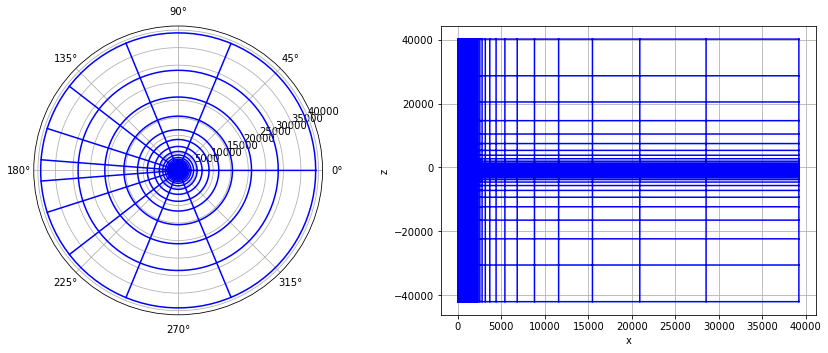

In [10]:
cylMeshGen.mesh.plotGrid()

In [11]:
print( 
    'nC: {}, max_x: {}, max_z: {}'.format(
        cylMeshGen.mesh.nC, cylMeshGen.mesh.vectorNx.max(), cylMeshGen.mesh.vectorNz.max()
    )
)

nC: 801306, max_x: 39214.3997434, max_z: 40184.9962552


In [12]:
cylMeshGen.mesh.vectorCCy

array([ 0.588141  ,  1.56837599,  2.22186599,  2.65752599,  2.94796599,
        3.14159265,  3.33521932,  3.62565932,  4.06131932,  4.71480931,
        5.69504431])

In [13]:
cylMeshGen.save(directory=simDir)

In [14]:
cylmesh = cylMeshGen.mesh

In [17]:
src = casingSimulations.sources.TopCasingSrc(cp=cp, meshGen=cylMeshGen, physics="FDEM")
src.save(directory=simDir)

NameError: global name 'os' is not defined

In [18]:
src.__class__

casingSimulations.sources.TopCasingSrc

(0.0, 1900)

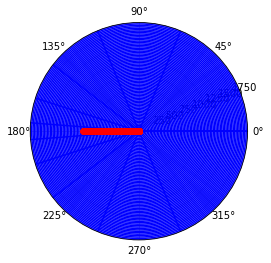

In [16]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1900])

(-10.0, 30.0)

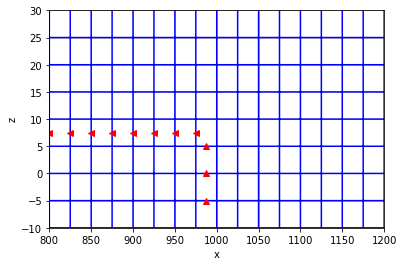

In [17]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([800., 1200.])
ax.set_ylim([-10., 30.])

In [18]:
physprops = casingSimulations.PhysicalProperties(cylmesh, cp)

In [19]:
mesh2D = discretize.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0 = cylmesh.x0)

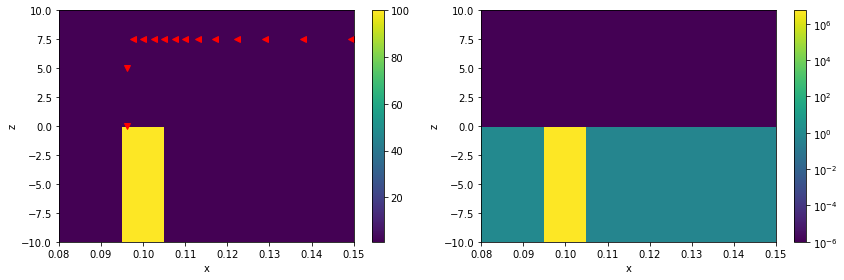

In [20]:
xlim = [0.08, 0.15]
ylim = [-10., 10.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

murplt = physprops.mur.reshape(cylmesh.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
src.plot(ax=ax[0])

sigmaplt = physprops.sigma.reshape(cylmesh.vnC, order='F')

plt.colorbar(
    mesh2D.plotImage(
        utils.mkvc(sigmaplt[:,0,:]), ax=ax[1], mirror=True, pcolorOpts = {'norm':LogNorm()}
    )[0], ax=ax[1],
    
)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

# Load up results

In [21]:
cylMesh=casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cyl_cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
cyl_hfield = np.load('/'.join([simDir, 'fieldsCyl.npy']))
# simulation = casingSimulations.load_properties(
#     '/'.join([simDir, 'simulationParameters.json']), 
#     targetClass=casingSimulations.run.SimulationFDEM
# )

In [136]:
cylSimulation = casingSimulations.run.SimulationFDEM(cp=cyl_cp, meshGenerator=cylMesh, srcType='TopCasingSrc')
cylSimulation.prob.model = cylSimulation.physprops.model
cylFields = cylSimulation.prob.fieldsPair(cylMesh.mesh, cylSimulation.survey)
cylFields[:,'hSolution'] = cyl_hfield
srcList = cylSimulation.survey.srcList

In [173]:
mesh = cylMesh.mesh
src = cylSimulation.src

In [24]:
cyl_cp.skin_depth()

array([ 63661.97723676,  36755.25969479,  20131.68484179,  11623.03366265,
         6366.19772368,   3675.52596948,   2013.16848418,   1423.52508683,
          900.31631616,    636.61977237])

In [82]:
# look at a slice along the plane of the source
srcind = 8
theta_ind = 5

jcyl = cylFields[srcList[srcind],'j']
jplt = casingSimulations.face3DthetaSlice(cylMesh.mesh, jcyl, theta_ind=theta_ind)

print('freq: {} Hz'.format(srcList[srcind].freq))


freq: 0.5 Hz


In [130]:
cylMeshGen.csx1

0.0025

In [129]:
print(cp.casing_t)

0.01


In [128]:
cp.skin_depth(sigma=cp.sigma_casing)

array([ 21.46044815,  12.39019552,   6.78638958,   3.91812385,
         2.14604481,   1.23901955,   0.67863896,   0.47987021,
         0.30349657,   0.21460448])

In [142]:
len(srcList)

10

In [132]:
import ipywidgets

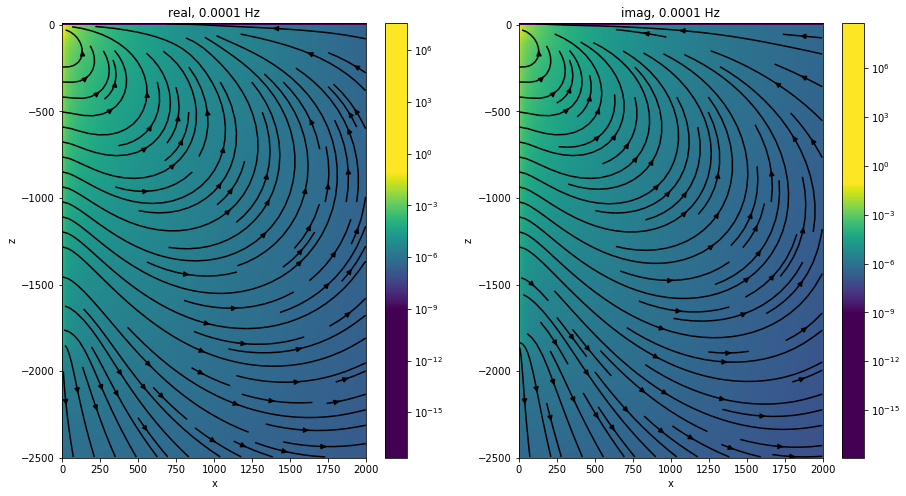

In [144]:
mesh2D = discretize.CylMesh([cylMesh.mesh.hx, 1., cylMesh.mesh.hz], x0=cylMesh.mesh.x0)

srcind = 2
theta_ind = 5

def plotCurrents(srcind=0, theta_ind=5):
    jcyl = cylFields[srcList[srcind],'j']
    jplt = casingSimulations.face3DthetaSlice(cylMesh.mesh, jcyl, theta_ind=theta_ind)

    fig, ax = plt.subplots(1,2, figsize=(15, 8))
    casingSimulations.plotFace2D(
        mesh2D,
        jplt, real_or_imag='real', ax=ax[0], range_x=np.r_[0., 2000.],
        range_y=np.r_[-2500., 10.], sample_grid=np.r_[10., 10.],
        logScale=True, clim=[1e-9, 1e-1]
    )
    ax[0].set_title('real, {} Hz'.format(srcList[srcind].freq))

    casingSimulations.plotFace2D(
        mesh2D,
        jplt, real_or_imag='imag', ax=ax[1], range_x=np.r_[0., 2000.],
        range_y=np.r_[-2500., 10.], sample_grid=np.r_[10., 10.],
        logScale=True, clim=[1e-9, 1e-1]
    )
    ax[1].set_title('imag, {} Hz'.format(srcList[srcind].freq))
    
    plt.show()

ipywidgets.interact(plotCurrents, srcind=ipywidgets.IntSlider(min=0, max=len(srcList)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=cylMeshGen.mesh.nCy-1, step=1))

In [70]:
theta_ind = 1
srcind = 7



In [71]:
# ex = eplt[:mesh2D.nC]
# ey = eplt[mesh2D.nC:2*mesh2D.nC]
# ez = eplt[2*mesh2D.nC:]

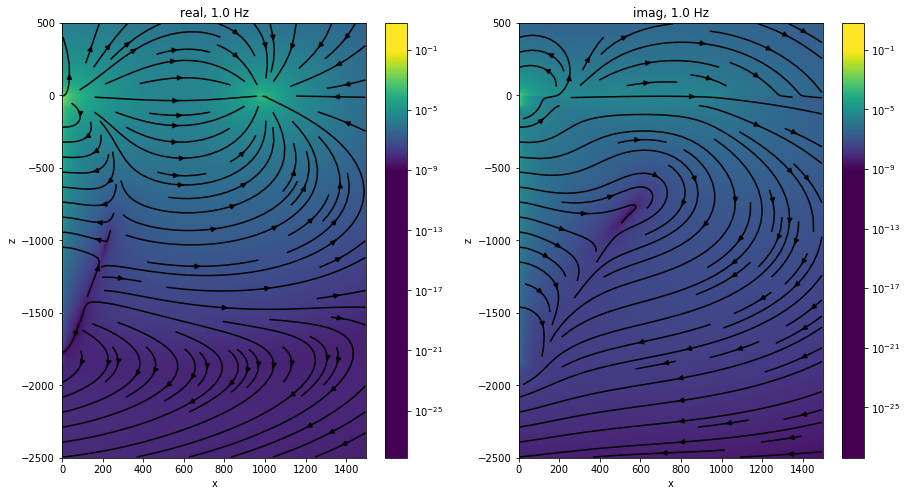

In [146]:
def plotEfield(srcind=0, theta_ind=5):
    fig, ax = plt.subplots(1,2, figsize=(15, 8))
    
    ecyl = cylFields[srcList[srcind], 'e']
    eplt = casingSimulations.face3DthetaSlice(cylmesh, ecyl, theta_ind=theta_ind)

    casingSimulations.plotFace2D(
        mesh2D,
        eplt, real_or_imag='real', ax=ax[0], range_x=np.r_[0., 1500.],
        range_y=np.r_[-2500., 500.], sample_grid=np.r_[10., 10.],
        logScale=True, clim=[1e-9, 1e-1]
    )
    ax[0].set_title('real, {} Hz'.format(srcList[srcind].freq))

    casingSimulations.plotFace2D(
        mesh2D,
        eplt, real_or_imag='imag', ax=ax[1], range_x=np.r_[0., 1500.],
        range_y=np.r_[-2500., 500.], sample_grid=np.r_[10., 10.],
        logScale=True, clim=[1e-9, 1e-1]
    )
    ax[1].set_title('imag, {} Hz'.format(srcList[srcind].freq))
    
    plt.show()

ipywidgets.interact(plotEfield, srcind=ipywidgets.IntSlider(min=0, max=len(srcList)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=cylMeshGen.mesh.nCy-1, step=1))

In [31]:
xind = ((mesh2D.gridFx[:,0] > 2.) & (mesh2D.gridFx[:,0] < 1800.)) 
zind = ((mesh2D.gridFx[:,2] > 0.) & (mesh2D.gridFx[:,2] < mesh2D.hz.min()))
pltind = xind & zind

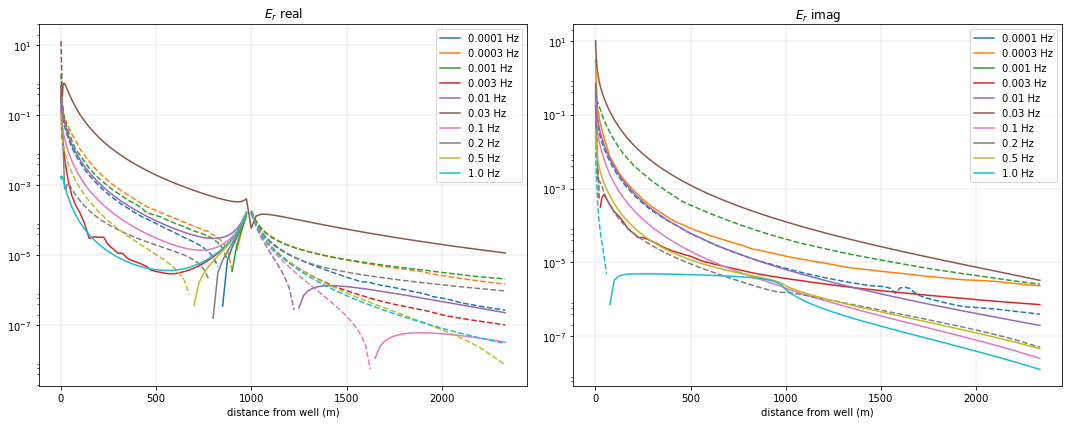

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = utils.mkvc(ax)

for i, src in enumerate(srcList):
    ecyl = cylFields[src, 'e']
    eplt = casingSimulations.face3DthetaSlice(cylmesh, ecyl, theta_ind=theta_ind)
    
    ex = utils.mkvc(eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F'))

#     ey = eplt[mesh2D.nC:2*mesh2D.nC]
#     ez = eplt[2*mesh2D.nC:]

    xind = ((mesh2D.gridFx[:,0] > 2.) & (mesh2D.gridFx[:,0] < 2500.)) 
    zind = ((mesh2D.gridFx[:,2] > -mesh2D.hz.min()) & (mesh2D.gridFx[:,2] < 0.))
    pltind = xind & zind
    
    ex = ex[pltind]
    x = mesh2D.gridFx[pltind, 0]
    
    label='{} Hz'.format(src.freq)
    
    ax[0].semilogy(x, -ex.real, '--', color='C{}'.format(i))
    ax[1].semilogy(x, -ex.imag, '--', color='C{}'.format(i))
    
#     ax[1].loglog(x, -ex.real, '--', color='C{}'.format(i))
#     ax[3].loglog(x, -ex.imag, '--', color='C{}'.format(i))
    
    ax[0].semilogy(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[1].semilogy(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    
#     ax[1].loglog(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
#     ax[3].loglog(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))

ax[0].legend()
ax[1].legend()

ax[0].set_title('$E_r$ real')
ax[1].set_title('$E_r$ imag')
# [a.set_xlim([2., 1000.]) for a in ax]
[a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8]) for a in ax]
[a.set_xlabel('distance from well (m)') for a in ax]

plt.tight_layout()

# solve the DC problem

In [159]:
from SimPEG.EM.Static import DC

In [165]:
a_electrode = cylMeshGen.mesh.gridFz[cylSimulation.src.tophole_electrode, :][0, :] - np.r_[0., 0., cylMeshGen.csz/2.] 
b_electrode = cylMeshGen.mesh.gridFz[cylSimulation.src.surface_electrode, :][0, :] - np.r_[0., 0., cylMeshGen.csz/2.] 

In [183]:
srcDC = DC.Src.Dipole([], src_a, src_b)
probDC = DC.Problem3D_CC(cylMeshGen.mesh, sigmaMap=physprops.wires.sigma, bc_type='Dirichlet', Solver=Pardiso)
surveyDC = DC.Survey([srcDC])

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [184]:
probDC.pair(surveyDC)

In [185]:
%%time
fieldsDC = probDC.fields(physprops.model)

CPU times: user 1min 5s, sys: 5.61 s, total: 1min 11s
Wall time: 51.4 s


In [186]:
jDC = fieldsDC[srcDC, 'j']
eDC = fieldsDC[srcDC, 'e']

In [174]:
theta_ind = 5
theta = mesh.vectorCCy[theta_ind]*180./np.pi
print('theta = {}'.format(theta))
jplt = casingSimulations.face3DthetaSlice(mesh, jDC, theta_ind=theta_ind)
eplt = casingSimulations.face3DthetaSlice(mesh, eDC, theta_ind=theta_ind)

theta = 180.0


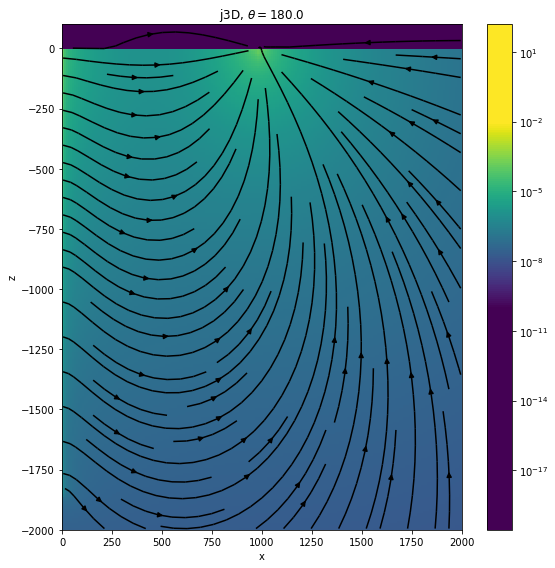

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 100.],
    'sample_grid':np.r_[10.,10.],
    'clim':np.r_[1e-10, 1e-2]
}

casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax, **pltargs
)

ax.set_title('j3D, $\\theta = {}$'.format(theta))


plt.tight_layout()

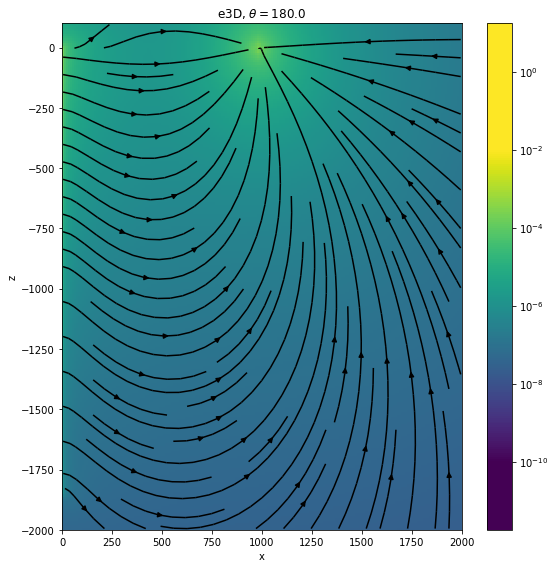

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 100.],
    'sample_grid':np.r_[10.,10.],
    'clim':np.r_[1e-10, 1e-2]
}

casingSimulations.plotFace2D(
    mesh2D, eplt, ax=ax, **pltargs
)

ax.set_title('e3D, $\\theta = {}$'.format(theta))


plt.tight_layout()

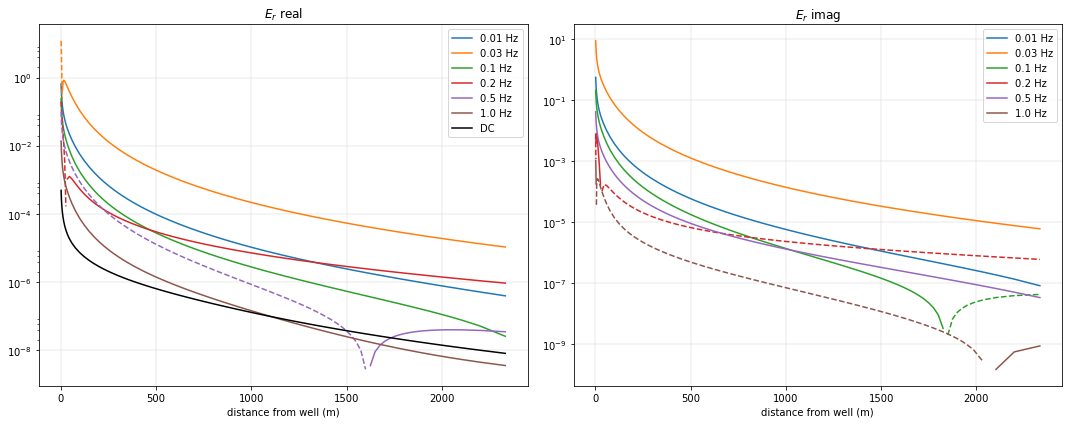

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = utils.mkvc(ax)

theta_ind=1

for i, src in enumerate(srcList[4:]):
    ecyl = cylFields[src, 'e']
    eplt = casingSimulations.face3DthetaSlice(cylmesh, ecyl, theta_ind=theta_ind)
    
    ex = utils.mkvc(eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F'))
    
    xind = ((mesh2D.gridFx[:,0] > 2.) & (mesh2D.gridFx[:,0] < 2500.)) 
    zind = ((mesh2D.gridFx[:,2] > -mesh2D.hz.min()) & (mesh2D.gridFx[:,2] < 0.))
    pltind = xind & zind
    
    ex = ex[pltind]
    x = mesh2D.gridFx[pltind, 0]
    
    label='{} Hz'.format(src.freq)
    
    ax[0].semilogy(x, -ex.real, '--', color='C{}'.format(i))
    ax[1].semilogy(x, -ex.imag, '--', color='C{}'.format(i))
    
    
    ax[0].semilogy(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[1].semilogy(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    

# plot the DC solution
exDC = casingSimulations.face3DthetaSlice(mesh, eDC, theta_ind=theta_ind)
exDC = utils.mkvc(exDC[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F'))
exDC = exDC[pltind]

ax[0].semilogy(x, -exDC, '--', color='k')
ax[0].semilogy(x, exDC, '-', color='k', label='DC')

ax[0].legend()
ax[1].legend()

ax[0].set_title('$E_r$ real')
ax[1].set_title('$E_r$ imag')
# [a.set_xlim([2., 1000.]) for a in ax]
[a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8]) for a in ax]
[a.set_xlabel('distance from well (m)') for a in ax]

plt.tight_layout()